In [1]:
#all imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model

In [9]:
tf.test.gpu_device_name()

'/device:GPU:0'

<pre><font size=6>1: Preprocessing</font></pre>

In [4]:
#Read the dataset - Amazon fine food reviews
reviews = pd.read_csv("Reviews.csv")
#check the info of the dataset
reviews.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [5]:
#get only 2 columns - Text, Score
reviews=reviews[["Text","Score"]]
#drop the NAN values
reviews = reviews.dropna(axis = 0, how ='any')

In [6]:
reviews.shape

(568454, 2)

In [7]:
#if score> 3, set score = 1
#if score<=2, set score = 0
#if score == 3, remove the rows. 
reviews=reviews[reviews.Score != 3]

def partition(x):
    if x < 3:
        return 0
    return 1

actualScore = reviews['Score']
positiveNegative = actualScore.map(partition) 
reviews['Score'] = positiveNegative

We are using reviews which has max length of 50. Also we are undersampling reviews from 500k to 100k. This is make the model run faster

In [9]:
def get_wordlen(x):
    return len(x.split())
reviews['len'] = reviews.Text.apply(get_wordlen)
reviews = reviews[reviews.len<50]
reviews = reviews.sample(n=100000, random_state=30)

In [ ]:
#remove HTML from the Text column and save in the Text column only
from bs4 import BeautifulSoup


preprocessed_reviews = []
for sentance in (reviews['Text'].values):
    #sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    preprocessed_reviews.append(sentance.strip())

In [24]:
#print head 5
reviews.head(5)

,Text,Score,len
0,The tea was of great quality and it tasted lik...,1,30
1,My cat loves this. The pellets are nice and s...,1,31
2,Great product. Does not completely get rid of ...,1,41
3,This gum is my favorite! I would advise every...,1,27
4,I also found out about this product because of...,1,22


In [14]:
#split the data into train and valudation data(20%) with Stratify sampling, random state 33, 

x_train, x_val, y_train, y_val = train_test_split(reviews.Text, reviews.Score, test_size=0.2, random_state=33,stratify=reviews.Score)

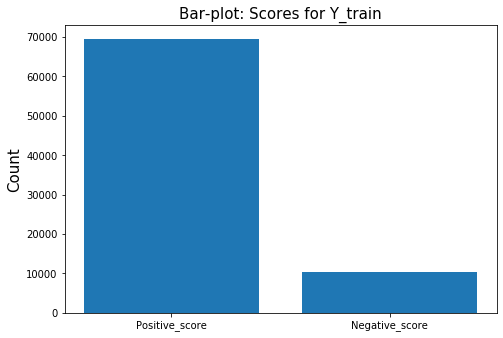

In [18]:
#plot bar graphs of y_train and y_test

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
pos= len(y_train[y_train==1].values)
neg= len(y_train[y_train==0].values)
score = ['Positive_score', 'Negative_score']
count=[pos,neg]
ax.bar(score,count)
plt.title("Bar-plot: Scores for Y_train",size=15)
plt.ylabel("Count",size=15)
plt.show()

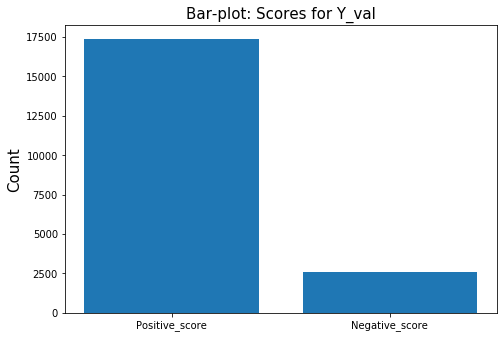

In [19]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
pos= len(y_val[y_val==1].values)
neg= len(y_val[y_val==0].values)
score = ['Positive_score', 'Negative_score']
count=[pos,neg]
ax.bar(score,count)
plt.title("Bar-plot: Scores for Y_val",size=15)
plt.ylabel("Count",size=15)
plt.show()

In [ ]:
#saving to disk. if we need, we can load preprocessed data directly. 
reviews.to_csv('preprocessed.csv', index=False)

In [24]:
reviews=pd.read_csv("preprocessed.csv")

<pre><font size=6>2: Creating BERT Model</font> 



For the feature extractor, we are using <a href="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1">BERT uncased Base model</a>. It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads. </pre>

In [2]:
## Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

# maximum length of a seq in the data we have, for now i am making it as 55. You can change this
max_seq_length = 55

#BERT takes 3 inputs

#this is input words. Sequence of words represented as integers
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Bert model
#We are using only pooled output not sequence out. 
#If you want to know about those, please read https://www.kaggle.com/questions-and-answers/86510
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)


In [3]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 55)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 55)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 55)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [4]:
bert_model.output

<tf.Tensor 'keras_layer/Identity:0' shape=(None, 768) dtype=float32>

<pre><font size=6>3: Tokenization</font></pre>

In [5]:
#getting Vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

we are`using tokenizer given by tensorflow https://github.com/tensorflow/models/tree/master/official/nlp/bert

In [6]:
#import tokenization - We have given tokenization.py file
import tokenization

In [7]:
# Create tokenizer " Instantiate FullTokenizer" 
# name must be "tokenizer"
# the FullTokenizer takes two parameters 1. vocab_file and 2. do_lower_case 
# we have created these in the above cell ex: FullTokenizer(vocab_file, do_lower_case )
# please check the "tokenization.py" file the complete implementation
tokenizer=tokenization.FullTokenizer(vocab_file, do_lower_case )

In [8]:
# Create train and test tokens (X_train_tokens, X_test_tokens) from (X_train, X_test) using Tokenizer and 
# add '[CLS]' at start of the Tokens and '[SEP]' at the end of the tokens. 
# maximum number of tokens is 55(We already given this to BERT layer above) so shape is (None, 55)
# if it is less than 55, add '[PAD]' token else truncate the tokens length.(similar to padding)
# Based on padding, create the mask for Train and Test ( 1 for real token, 0 for '[PAD]'), 
# it will also same shape as input tokens (None, 55) save those in X_train_mask, X_test_mask
# Create a segment input for train and test. We are using only one sentence so all zeros. This shape will also (None, 55)
# type of all the above arrays should be numpy arrays
# after execution of this cell, you have to get 
# X_train_tokens, X_train_mask, X_train_segment
# X_test_tokens, X_test_mask, X_test_segment

def get_ids(tokens, tokenizer, max_seq_length):
    
    if len(tokens)>max_seq_length-2:
        
        tokens = tokens[:max_seq_length-2]
        tokens=  ["[CLS]"] + tokens + ["[SEP]"]
        token_ids = tokenizer.convert_tokens_to_ids(tokens)
        return token_ids
    else:
        
        tokens=  ["[CLS]"] + tokens + ["[SEP]"]
        token_ids = tokenizer.convert_tokens_to_ids(tokens)
        input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
        return input_ids


def get_masks(tokens, max_seq_length):
    tokens= ["[CLS]"] + tokens + ["[SEP]"]
    if len(tokens)>max_seq_length:
        
        #Cutting down the excess length
        tokens = tokens[0:max_seq_length]
        return [1]*len(tokens)
    else :
        
        return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))
    

    
    

In [47]:
X_train_tokens=[]
X_train_mask=[]

for item in (tqdm_notebook(x_train.values)):
    
    stokens1=tokenizer.tokenize(item)
    #stokens1 = ["[CLS]"] + stokens1 + ["[SEP]"]
    
    input_ids1 = np.array(get_ids(stokens1, tokenizer, max_seq_length))
    X_train_tokens.append(input_ids1)
   
    input_mask = np.array(get_masks(stokens1,max_seq_length))
    X_train_mask.append(input_mask)
    
X_test_tokens=[]
X_test_mask=[]

for item in tqdm_notebook(x_val.values):
    
    stokens1=tokenizer.tokenize(item)
    #stokens1 = ["[CLS]"] + stokens1 + ["[SEP]"]
    
    input_ids1 = np.array(get_ids(stokens1, tokenizer, max_seq_length))
    X_test_tokens.append(input_ids1)
    
    input_mask = np.array(get_masks(stokens1,max_seq_length))
    X_test_mask.append(input_mask)
    
X_train_tokens =  np.array(X_train_tokens)
X_test_tokens  =  np.array(X_test_tokens)

X_train_mask   =  np.array(X_train_mask)  
X_test_mask    =  np.array(X_test_mask)

X_train_segment=  np.zeros((len(x_train),55))
X_test_segment =  np.zeros((len(x_val),55))

S:\ana\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


S:\ana\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [1]:
import pickle

In [49]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((x_train, X_train_tokens, X_train_mask, X_train_segment, y_train),open('train_data.pkl','wb'))
pickle.dump((x_val, X_test_tokens, X_test_mask, X_test_segment, y_val),open('test_data.pkl','wb'))

In [5]:
#you can load from disk
X_train, X_train_tokens, X_train_mask, X_train_segment, y_train = pickle.load(open("train_data.pkl", 'rb')) 
X_test, X_test_tokens, X_test_mask, X_test_segment, y_test = pickle.load(open("test_data.pkl", 'rb')) 

<pre><font size=6>4: Getting Embeddings from BERT Model</font>
We already created the BERT model in the part-2 and input data in the part-3. We will utlize those two and will get the embeddings for each sentence in the Train and Validation data.</pre>

In [42]:
bert_model.input

[<tf.Tensor 'input_word_ids:0' shape=(None, 55) dtype=int32>,
 <tf.Tensor 'input_mask:0' shape=(None, 55) dtype=int32>,
 <tf.Tensor 'segment_ids:0' shape=(None, 55) dtype=int32>]

In [43]:
bert_model.output

<tf.Tensor 'keras_layer/Identity:0' shape=(None, 768) dtype=float32>

In [44]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 55)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 55)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 55)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [45]:
# get the train output, BERT model will give one output so save in
X_train_pooled_output = bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])

In [46]:
# get the test output, BERT model will give one output so save in
X_test_pooled_output = bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

In [58]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train_pooled_output, X_test_pooled_output),open('final_output.pkl','wb'))

In [17]:
X_train_pooled_output, X_test_pooled_output= pickle.load(open('final_output.pkl', 'rb'))

<pre><font size=6>Part-5: Training a NN </font>



In [25]:
##imports
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

In [26]:
##create an NN and 
tf.keras.backend.clear_session()
#model_architecture
input_layer = Input(shape=(768,))
layer1 = Dense(128,activation='relu',kernel_initializer='he_normal')(input_layer)
layer1=Dropout(rate=0.4)(layer1)

layer2 = Dense(64,activation='relu',kernel_initializer='he_normal')(layer1)
layer2=Dropout(rate=0.4)(layer2)

layer3= Dense(32,activation='relu',kernel_initializer='he_normal')(layer2)

layer4= Dense(16,activation='relu',kernel_initializer='he_normal')(layer3)

output = Dense(2,activation='softmax',kernel_initializer='he_normal')(layer4)

model = Model(inputs=input_layer,outputs=output)

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               98432     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528   

In [31]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=[tf.keras.metrics.AUC(name='auc')])

In [33]:
y_train=tf.keras.utils.to_categorical(y_train.values, 2)
y_test=tf.keras.utils.to_categorical(y_test.values, 2) 

In [34]:
log_dir=".\logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)
check = ModelCheckpoint("mod/best.hdf5", monitor = 'val_loss')
es=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=4,restore_best_weights=True)
model.fit(X_train_pooled_output,y_train,epochs=25,validation_data =(X_test_pooled_output, y_test),batch_size=128,callbacks=[tensorboard_callback,check,es],verbose=1)
model.save('mod/20epochs.hdf5')

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
  128/80000 [..............................] - ETA: 7:31 - loss: 0.2372 - auc: 0.9641WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.817365). Check your callbacks.


80000/80000 [==============================] - 7s 85us/sample - loss: 0.2497 - auc: 0.9599 - val_loss: 0.2501 - val_auc: 0.9703
Epoch 2/25
80000/80000 [==============================] - 2s 31us/sample - loss: 0.2436 - auc: 0.9622 - val_loss: 0.2202 - val_auc: 0.9745
Epoch 3/25
80000/80000 [==============================] - 2s 29us/sample - loss: 0.2438 - auc: 0.9611 - val_loss: 0.2179 - val_auc: 0.9745
Epoch 4/25
80000/80000 [==============================] - 2s 30us/sample - loss: 0.2324 - auc: 0.9658 - val_loss: 0.2208 - val_auc: 0.9720
Epoch 5/25
80000/80000 [==============================] - 2s 30us/sample - loss: 0.2291 - auc: 0.9668 - val_loss: 0.2330 - val_auc: 0.9743
Epoch 6/25
80000/80000 [==============================] - 2s 30us/sample - loss: 0.2310 - auc: 0.9660 - val_loss: 0.2324 - val_auc: 0.9755
Epoch 7/25
80000/80000 [==============================] - 2s 29us/sample - loss: 0.2246 - auc: 0.9677 - val_loss: 0.2590 - val_auc: 0.9769


In [35]:
from IPython.display import Image

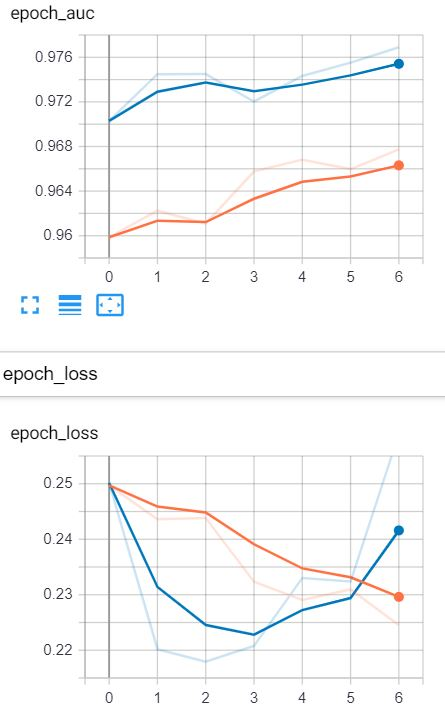

In [36]:
Image('loss.jpg')

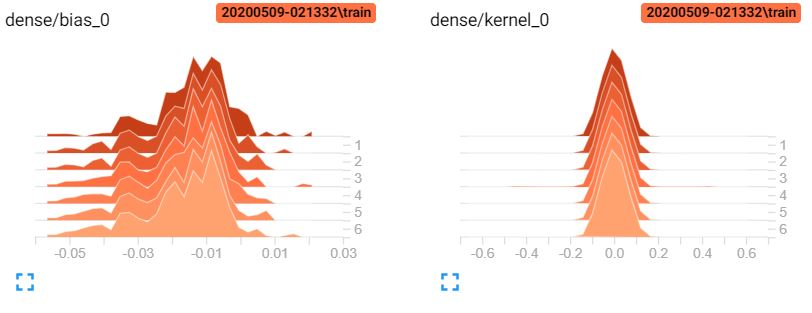

In [37]:
Image('weights.jpg')

### Observations:

1. Maximum validation AUC-ROC score is around 0.977
2. There seems to be no overfitting or underfitting
3. gradients and weights seem to be fine

<Pre><font size=6>6: Creating a Data pipeline for BERT Model</font> 



In [70]:
#loadind file
df=pd.read_csv("test.csv")

In [71]:
#removing html tags
preprocessed_reviews = []
for sentance in (df['Text'].values):
    #sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    preprocessed_reviews.append(sentance.strip())
df["Text"]=preprocessed_reviews

In [72]:
df.to_csv("finalpred.csv",index=False)

In [9]:
df=pd.read_csv("finalpred.csv")

In [10]:
# craeting tokens ,mask, segments
test_tokens=[]
test_mask=[]

for item in tqdm_notebook(df["Text"].values):
    
    stokens1=tokenizer.tokenize(item)
    #stokens1 = ["[CLS]"] + stokens1 + ["[SEP]"]
    
    input_ids1 = np.array(get_ids(stokens1, tokenizer, max_seq_length))
    test_tokens.append(input_ids1)
    
    input_mask = np.array(get_masks(stokens1,max_seq_length))
    test_mask.append(input_mask)
    

test_tokens  =  np.array(test_tokens)
  
test_mask    =  np.array(test_mask)

test_segment =  np.zeros((len(df),55))

S:\ana\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [11]:
test_pooled_output=bert_model.predict([test_tokens,test_mask ,test_segment])

In [12]:
test_pooled_output.shape

(352, 768)

In [13]:
#Loading saved model
from tensorflow.keras.models import load_model
model=load_model("mod/best.hdf5")

In [14]:
ypred_probabilities=model.predict([test_pooled_output])

In [16]:
#displaying probability scores
y_classes = ypred_probabilities.argmax(axis=-1)

In [17]:
y_classes

array([0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [23]:
neg=len(np.where(y_classes == 0)[0])
pos=len(np.where(y_classes == 1)[0])
print("Number of negative reviews in test data:",neg)
print("Number of positive reviews in test data:",pos)

Number of negative reviews in test data: 39
Number of positive reviews in test data: 313


# Brief Approach and Conclusions:

1. The dataset contained 100,000 reviews on products belonging to 2 classes. Objective was to build a BERT classifier to classify the reviews.
2. Class imbalance was observed
3. The data was prepocessed and 80-20 split was performed.
4. A pretrained BERT model with 12 attention heads and hidden size of 768 was used.
5. Using sentence vectors from BERT, a simple neural network was trained. It achieved a validation AUC score of 0.97
6. The model was then used to predict for test data (unseen class labels) 